In [64]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.linear_model import TweedieRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_tweedie_deviance, d2_tweedie_score, make_scorer
import itertools

from tqdm.notebook import tqdm

In [65]:
%run py/ModelPlot.py
%run py/triangle
%run py/TriangleTimeSeriesSplit
%run py/rockycore
%run py/GLM

from importlib import reload
import py
reload(py)

import py.rockycore, py.triangle, py.TriangleTimeSeriesSplit, py.GLM, py.ModelPlot

reload(py.ModelPlot)
from py.ModelPlot import Plot

reload(py.triangle)
from py.triangle import Triangle

reload(py.rockycore)
from py.rockycore import ROCKY

reload(py.TriangleTimeSeriesSplit)
from py.TriangleTimeSeriesSplit import TriangleTimeSeriesSplit

reload(py.GLM)
from py.GLM import glm

In [66]:
r = ROCKY()
r.FromCSV('../../paid.csv', origin_columns=1, id='paid_loss')

In [67]:
r.AddModel(id='BaseGLM', tri=r.paid_loss, cal=False, n_validation=5)

In [68]:
# r.BaseGLM.TuneFitHyperparameters()
r.BaseGLM.SetHyperparameters(alpha=0.1, power=2.4)
r.BaseGLM.Fit()

In [69]:
def create_obs_vs_pred_plot(self, y=None, yhat=None, color='acc', trendline='ols', opacity=0.5, hover_data=None, title='Observations vs. Predictions', log=False):
    # Create a copy of the dataframe to avoid modifying the original data

    if y is None:
        y = self.GetY()

    if yhat is None:
        yhat = self.GetYhat()

    if hover_data is None:
        hover_data = ['acc', 'dev', 'cal', 'y', 'yhat']

    obs_vs_pred = pd.DataFrame({
        'y': y if not log else np.log(y),
        'yhat': yhat if not log else np.log(yhat),
        'acc': self.acc,
        'dev': self.dev,
        'cal': self.cal
    })
    
    # Recode the color variable to be categorical if it's numeric
    if pd.api.types.is_numeric_dtype(obs_vs_pred[color]):
        obs_vs_pred[color] = obs_vs_pred[color].astype(str)
    
    # Create the scatter plot
    fig = px.scatter(obs_vs_pred, x='y', y='yhat', color=color, trendline=trendline, opacity=opacity, 
                     hover_data=hover_data, title=title, labels={'y': 'Observed', 'yhat': 'Predicted'})
    
    # Add a 45-degree black dashed line
    fig.add_shape(type='line', x0=obs_vs_pred['y'].min(), y0=obs_vs_pred['yhat'].min(),
                  x1=obs_vs_pred['y'].max(), y1=obs_vs_pred['yhat'].max(),
                  line=dict(color='black', dash='dash'))
    
    # Update marker properties to include thin black outlines
    fig.update_traces(marker=dict(line=dict(color='black', width=0.75)))
    
    # Show the plot
    fig.show()

self = r.BaseGLM
create_obs_vs_pred_plot(self, log=True)


In [73]:
from dataclasses import dataclass

@dataclass
class test:
    a1: int = 1
    a2: int = 2
    aNone: int = None
    aNone2: int = None

t = test()
t.aNone2

In [71]:
r.BaseGLM.plot.obs_pred()

AttributeError: 'Plot' object has no attribute 'yhat'

In [20]:
obs_vs_pred = pd.DataFrame({'acc': r.BaseGLM.acc, 'dev': r.BaseGLM.dev, 'cal':r.BaseGLM.cal, 'y': r.BaseGLM.GetY(), 'yhat': r.BaseGLM.GetYhat()})
px.scatter(obs_vs_pred, x='y', y='yhat', color='acc', trendline='ols', opacity=0.5, hover_data=['acc', 'dev', 'cal', 'y', 'yhat'])

<Axes: xlabel='var'>

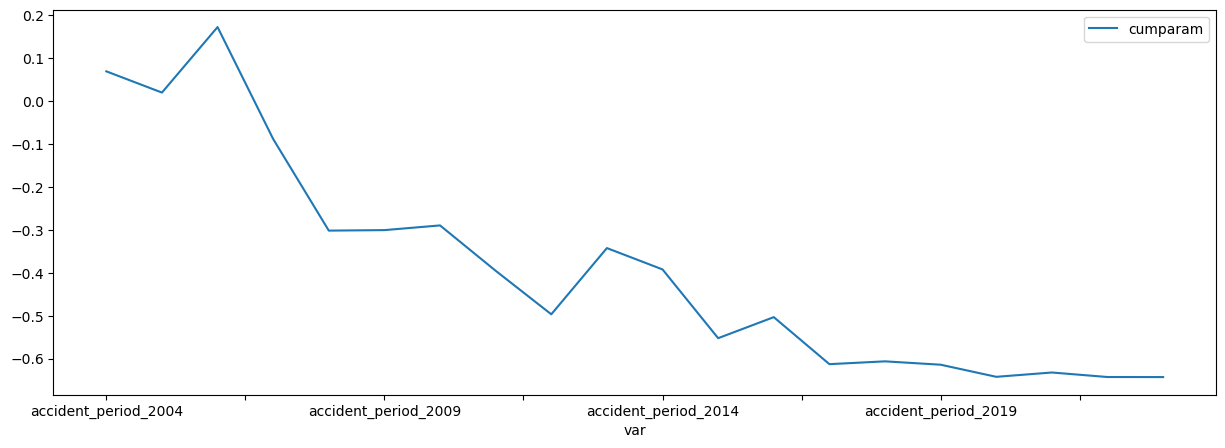

In [141]:
df = pd.DataFrame({
  'var':r.BaseGLM.model.feature_names_in_,
'param':r.BaseGLM.coef    
}).loc[lambda x: x['var'].str.contains('accident') | x['var'].str.contains('ntercept')]
df['cumparam'] = df['param'].cumsum() + df.loc[df['var'].eq('intercept'), 'param'].values
df.set_index('var').plot(kind='line', y='cumparam', figsize=(15,5))

<Axes: xlabel='y', ylabel='yhat'>

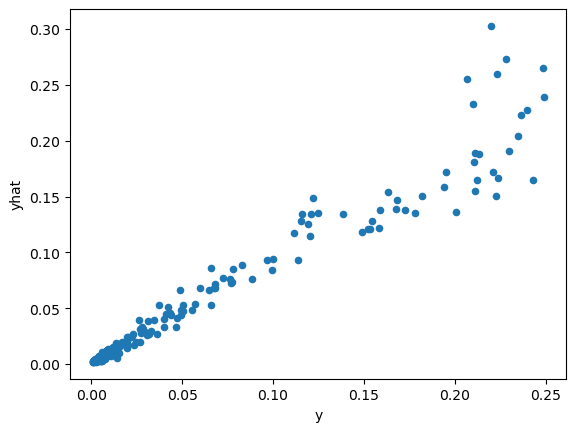

In [142]:
pd.DataFrame({
    'yhat':r.BaseGLM.Predict()
    , 'y': r.BaseGLM.GetY()
}).plot(kind='scatter', x='y', y='yhat')

resid    Axes(0.125,0.11;0.775x0.77)
dtype: object

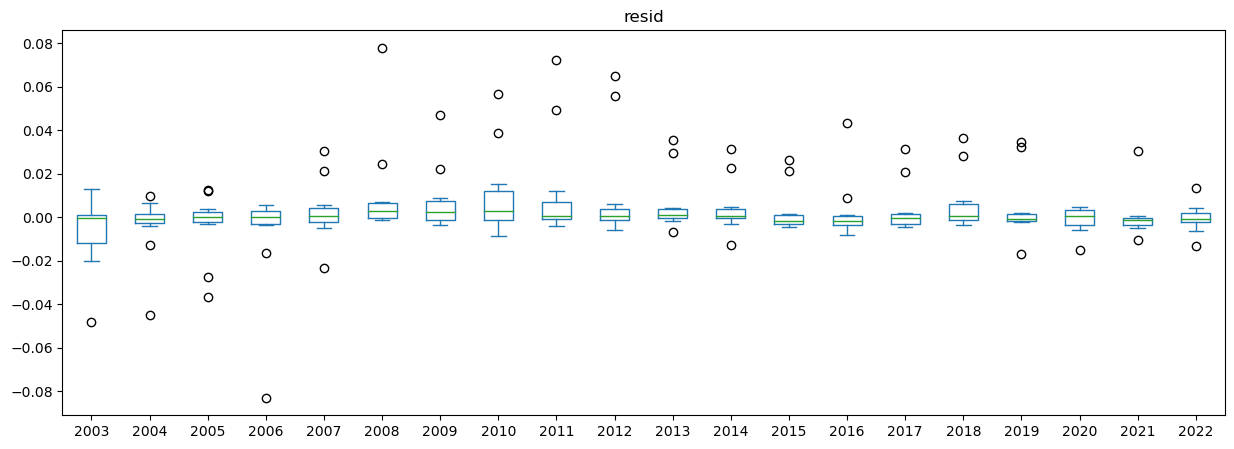

In [144]:
pd.DataFrame({
    'resid': r.BaseGLM.(),
    'cal': r.paid_loss.get_X_id().accident_period,
}).plot(kind='box', by='cal', figsize=(15,5))

In [146]:
r.BaseGLM.PearsonResiduals(show_plot=True)

TypeError: can only concatenate str (not "NoneType") to str

In [146]:
r.BaseGLM.plot.ResidualPlot(r.BaseGLM.PearsonResiduals(), r.paid_loss.get_X_id('train').accident_period)

AttributeError: 'glm' object has no attribute 'plot'

In [138]:
scatterpoint_outline_color=(0, 0, 0, 0)
outline_color = 'rgba' + str(scatterpoint_outline_color)
outline_color

'rgba(0, 0, 0, 0)'

In [97]:
r.paid_loss.get_X_id().head()

,accident_period,development_period,cal
0,2003,12,1
1,2004,12,2
2,2005,12,3
3,2006,12,4
4,2007,12,5


In [95]:
r.BaseGLM.PearsonResiduals()

0     -0.095693
1     -0.085978
2     -0.071927
3     -0.150937
4     -0.048243
         ...   
205   -0.027310
206   -0.027052
207    0.050904
208    0.032281
209   -0.027597
Name: paid_loss, Length: 210, dtype: float64

## triangle CV below

In [273]:
reload(py.TriangleTimeSeriesSplit)
from py.TriangleTimeSeriesSplit import TriangleTimeSeriesSplit
cv = TriangleTimeSeriesSplit(r.paid_loss, n_splits=5)

In [274]:
cv.TuneTweedie()

Training models with data through 2017: 100%|██████████| 441/441 [00:07<00:00, 59.90it/s]


In [275]:
cv.TweedieParetoFront({
    'ave_mse_test':'min',
    'sd_mse_test':'min',
    'ave_mae_test':'min',
    })

,ave_mse_train,sd_mse_train,cv_mse_train,ave_mse_test,sd_mse_test,cv_mse_test,ave_d2_train,sd_d2_train,cv_d2_train,ave_d2_test,sd_d2_test,cv_d2_test,ave_mae_train,sd_mae_train,cv_mae_train,ave_mae_test,sd_mae_test,cv_mae_test,alpha,p
alpha_0.0_p_3.0,0.001088,0.000331,0.304704,0.000116,0.000059,0.514395,0.918708,0.019105,0.020796,0.686524,0.008976,0.013075,0.013382,0.002254,0.168401,0.005249,0.00106,0.201871,0.0,3.0


In [278]:
r.paid_loss.get_X_base(cal=True)

,accident_period_2004,accident_period_2005,accident_period_2006,accident_period_2007,accident_period_2008,accident_period_2009,accident_period_2010,accident_period_2011,accident_period_2012,accident_period_2013,...,cal_0030,cal_0031,cal_0032,cal_0033,cal_0034,cal_0035,cal_0036,cal_0037,cal_0038,cal_0039
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,0,0,0
396,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,0,0
397,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
398,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0


In [269]:
cv.tweedie_result.sort_values('ave_mse_test')

,ave_mse_train,sd_mse_train,cv_mse_train,ave_mse_test,sd_mse_test,cv_mse_test,ave_d2_train,sd_d2_train,cv_d2_train,ave_d2_test,sd_d2_test,cv_d2_test,alpha,p
alpha_0.1_p_3.0,0.000789,0.000237,0.300392,0.000110,0.000018,0.168268,0.918443,0.019077,0.020771,0.689705,0.009541,0.013833,0.1,3.0
alpha_0.1_p_2.9,0.000654,0.000176,0.268532,0.000112,0.000017,0.151699,0.926452,0.015952,0.017219,0.720718,0.010671,0.014805,0.1,2.9
alpha_0.1_p_2.8,0.000538,0.000125,0.232272,0.000115,0.000016,0.137524,0.933716,0.013150,0.014083,0.750525,0.011859,0.015800,0.1,2.8
alpha_0.0_p_3.0,0.001088,0.000331,0.304694,0.000116,0.000060,0.515410,0.918708,0.019105,0.020796,0.686524,0.008979,0.013079,0.0,3.0
alpha_0.2_p_3.0,0.000659,0.000179,0.271973,0.000116,0.000015,0.129277,0.917927,0.018972,0.020668,0.692154,0.010090,0.014578,0.2,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
alpha_1.6_p_1.0,0.005867,0.000318,0.054209,0.003593,0.000625,0.173978,0.089100,0.003055,0.034291,-0.698233,0.032739,-0.046888,1.6,1.0
alpha_1.7000000000000002_p_1.0,0.005896,0.000322,0.054531,0.003616,0.000629,0.173889,0.084322,0.002910,0.034506,-0.705216,0.032719,-0.046395,1.7,1.0
alpha_1.8_p_1.0,0.005923,0.000325,0.054821,0.003638,0.000632,0.173828,0.080027,0.002775,0.034677,-0.711512,0.032722,-0.045990,1.8,1.0
alpha_1.9000000000000001_p_1.0,0.005946,0.000328,0.055082,0.003657,0.000635,0.173775,0.076147,0.002653,0.034837,-0.717206,0.032726,-0.045629,1.9,1.0


In [219]:
cv.tweedie_result.assign(sortby=cv.tweedie_result['ave_mse_test'] * cv.tweedie_result['sd_mse_test']).sort_values('sortby').T

,alpha_0.1_p_2.4,alpha_0.1_p_2.5,alpha_0.1_p_2.6,alpha_0.2_p_2.8,alpha_0.2_p_2.9,alpha_0.2_p_2.7,alpha_0.1_p_2.7,alpha_0.2_p_3.0,alpha_0.1_p_2.3,alpha_0.30000000000000004_p_3.0,...,alpha_1.8_p_1.1,alpha_1.4000000000000001_p_1.0,alpha_1.9000000000000001_p_1.1,alpha_2.0_p_1.1,alpha_1.5_p_1.0,alpha_1.6_p_1.0,alpha_1.7000000000000002_p_1.0,alpha_1.8_p_1.0,alpha_1.9000000000000001_p_1.0,alpha_2.0_p_1.0
ave_mse_train,2.978066e-04,3.198087e-04,3.679250e-04,4.630627e-04,5.473972e-04,4.097326e-04,4.412130e-04,6.592913e-04,3.012995e-04,5.952825e-04,...,0.005795,0.005797,0.005824,0.005851,0.005834,0.005867,0.005896,0.005923,0.005946,0.005968
sd_mse_train,1.951462e-05,3.318946e-05,5.428135e-05,8.097555e-05,1.239072e-04,5.019819e-05,8.454232e-05,1.793093e-04,1.185931e-05,1.399271e-04,...,0.000314,0.000310,0.000317,0.000320,0.000314,0.000318,0.000322,0.000325,0.000328,0.000330
cv_mse_train,6.552782e-02,1.037791e-01,1.475337e-01,1.748695e-01,2.263571e-01,1.225145e-01,1.916134e-01,2.719728e-01,3.936053e-02,2.350600e-01,...,0.054215,0.053422,0.054511,0.054772,0.053836,0.054209,0.054531,0.054821,0.055082,0.055318
ave_mse_test,1.312684e-04,1.263688e-04,1.221007e-04,1.227905e-04,1.193238e-04,1.264005e-04,1.182694e-04,1.162075e-04,1.368026e-04,1.197669e-04,...,0.003498,0.003537,0.003523,0.003545,0.003567,0.003593,0.003616,0.003638,0.003657,0.003674
sd_mse_test,1.260809e-05,1.313256e-05,1.383507e-05,1.398045e-05,1.440234e-05,1.363907e-05,1.474471e-05,1.502295e-05,1.287674e-05,1.489417e-05,...,0.000615,0.000616,0.000619,0.000623,0.000622,0.000625,0.000629,0.000632,0.000635,0.000638
cv_mse_test,9.604824e-02,1.039225e-01,1.133087e-01,1.138561e-01,1.206996e-01,1.079036e-01,1.246706e-01,1.292769e-01,9.412640e-02,1.243597e-01,...,0.175667,0.174213,0.175659,0.175631,0.174249,0.173978,0.173889,0.173828,0.173775,0.173730
ave_d2_train,9.534356e-01,9.499945e-01,9.455612e-01,9.321788e-01,9.255419e-01,9.376865e-01,9.401186e-01,9.179267e-01,9.559144e-01,9.172747e-01,...,0.100129,0.100488,0.095399,0.091093,0.094451,0.089100,0.084322,0.080027,0.076147,0.072625
sd_d2_train,4.747504e-03,6.471718e-03,8.435010e-03,1.282376e-02,1.575975e-02,1.014446e-02,1.065111e-02,1.897190e-02,3.274384e-03,1.880926e-02,...,0.002440,0.003406,0.002322,0.002225,0.003219,0.003055,0.002910,0.002775,0.002653,0.002541
cv_d2_train,4.979366e-03,6.812374e-03,8.920639e-03,1.375676e-02,1.702759e-02,1.081860e-02,1.132954e-02,2.066821e-02,3.425395e-03,2.050559e-02,...,0.024371,0.033896,0.024343,0.024429,0.034081,0.034291,0.034506,0.034677,0.034837,0.034985
ave_d2_test,8.465489e-01,8.273817e-01,8.045323e-01,7.533266e-01,7.235269e-01,7.807617e-01,7.786730e-01,6.921544e-01,8.614300e-01,6.940843e-01,...,-0.634044,-0.681782,-0.640844,-0.646971,-0.690554,-0.698233,-0.705216,-0.711512,-0.717206,-0.722376


In [39]:
xgb_models = {}
xgb_scores = {}
xgb_df_dict = {}


# for a, p in itertools.product(tweedie_grid['alpha'], tweedie_grid['power']):
#     tweedie_name = f'TweedieRegressor_Alpha-{a}_P-{p}'
#     models[tweedie_name] = {}
#     scores[tweedie_name] = {}
#     df_dict[tweedie_name] = {'alpha': a, 'power': p, 'model': 'TweedieRegressor'}

xgb_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.2, 0.3],
    'reg_lambda': [0],
    'reg_alpha': [0],
    'gamma': [0, 0.1, 0.5, 1],
    'subsample': [0.5, 0.75, 1],
}

def xgb_name(n, d, l, la, a, g, s):
    return f'XGBRegressor_nEstimators-{n}_MaxDepth-{d}_LearnRt-{l}_Lambda-{la}_Alpha-{a}_Gamma-{g}_Subsample-{s}'

for n, d, l, la, a, g, s in itertools.product(xgb_grid['n_estimators'], xgb_grid['max_depth'], xgb_grid['learning_rate'], xgb_grid['reg_lambda'], xgb_grid['reg_alpha'], xgb_grid['gamma'], xgb_grid['subsample']):
    nm = xgb_name(n, d, l, la, a, g, s)
    xgb_models[nm] = {}
    xgb_scores[nm] = {}
    xgb_df_dict[nm] = {'n_estimators': n, 'max_depth': d, 'learning_rate': l, 'reg_lambda': la, 'reg_alpha': a, 'gamma': g, 'subsample': s, 'model': 'XGBRegressor'}
    

for train, test in cv.GetSplit():
    X_train = r.paid_loss.get_X_base().iloc[train]
    y_train = r.paid_loss.get_y_base().iloc[train]
    X_id_train = r.paid_loss.get_X_id().iloc[train]
    
    X_test = r.paid_loss.get_X_base().iloc[test]
    y_test = r.paid_loss.get_y_base().iloc[test]
    X_id_test = r.paid_loss.get_X_id().iloc[test]

    print(f"Calendar periods from {X_id_test.cal.min()} to {X_id_test.cal.max()}")

    total_len = 1
    for k in xgb_grid.keys():
        total_len *= len(xgb_grid[k])

    print(f"Number of models: {total_len}")  

    for n, d, l, la, a, g, s in tqdm(itertools.product(xgb_grid['n_estimators'], xgb_grid['max_depth'], xgb_grid['learning_rate'], xgb_grid['reg_lambda'], xgb_grid['reg_alpha'], xgb_grid['gamma'], xgb_grid['subsample'])):
        nm = xgb_name(n, d, l, la, a, g, s)
        xgb_models[nm][f"cy_{X_id_test.cal.min()}"] = XGBRegressor(n_estimators=n, max_depth=d, learning_rate=l, reg_lambda=la, reg_alpha=a, gamma=g, subsample=s).fit(X_train, y_train)
        xgb_scores[nm][f"cy_{X_id_test.cal.min()}"] = xgb_models[nm][f"cy_{X_id_test.cal.min()}"].score(X_test, y_test)
        xgb_df_dict[nm][f"cy_{X_id_test.cal.min()}_score"] = xgb_scores[nm][f"cy_{X_id_test.cal.min()}"]
        xgb_df_dict[nm][f"cy_{X_id_test.cal.min()}_mse"] = mean_squared_error(y_test, xgb_models[nm][f"cy_{X_id_test.cal.min()}"].predict(X_test))
        xgb_df_dict[nm][f"cy_{X_id_test.cal.min()}_mae"] = mean_absolute_error(y_test, xgb_models[nm][f"cy_{X_id_test.cal.min()}"].predict(X_test))
        

    # TweedieRegressor
    # print('\nTWEEDIE REGRESSOR')
    # print('-----------------')
    # for a, p in itertools.product(tweedie_grid['alpha'], tweedie_grid['power']):
    #     tweedie_name = f'TweedieRegressor_Alpha-{a}_P-{p}'
    #     models[tweedie_name][f"cy_{X_id_test.cal.min()}"] = TweedieRegressor(alpha=a, power=p, max_iter=10000).fit(X_train, y_train)
    #     scores[tweedie_name][f"cy_{X_id_test.cal.min()}"] = models[tweedie_name][f"cy_{X_id_test.cal.min()}"].score(X_test, y_test)
    #     df_dict[tweedie_name][f"cy_{X_id_test.cal.min()}_score"] = scores[tweedie_name][f"cy_{X_id_test.cal.min()}"]
    #     df_dict[tweedie_name][f"cy_{X_id_test.cal.min()}_mse"] = mean_squared_error(y_test, models[tweedie_name][f"cy_{X_id_test.cal.min()}"].predict(X_test))
    #     # df_dict[tweedie_name][f"cy_{X_id_test.cal.min()}_mean_sq_err"] = mse_score(models[tweedie_name][f"cy_{X_id_test.cal.min()}"], X_test, y_test)
    #     df_dict[tweedie_name][f"cy_{X_id_test.cal.min()}_mae"] = mean_absolute_error(y_test, models[tweedie_name][f"cy_{X_id_test.cal.min()}"].predict(X_test))
    #     df_dict[tweedie_name][f"cy_{X_id_test.cal.min()}_deviance"] = mean_tweedie_deviance(y_test, models[tweedie_name][f"cy_{X_id_test.cal.min()}"].predict(X_test), power=p)
    #     df_dict[tweedie_name][f"cy_{X_id_test.cal.min()}_d2"] = d2_tweedie_score(y_test, models[tweedie_name][f"cy_{X_id_test.cal.min()}"].predict(X_test), power=p)



Calendar periods from 19 to 20
Number of models: 432


0it [00:00, ?it/s]

Calendar periods from 18 to 20
Number of models: 432


0it [00:00, ?it/s]

Calendar periods from 17 to 20
Number of models: 432


0it [00:00, ?it/s]

Calendar periods from 16 to 20
Number of models: 432


0it [00:00, ?it/s]

Calendar periods from 15 to 20
Number of models: 432


0it [00:00, ?it/s]

In [63]:

mse_score = make_scorer(mean_squared_error, greater_is_better=False)
mae_score = make_scorer(mean_absolute_error, greater_is_better=False)
mt_dev_score = make_scorer(mean_tweedie_deviance, greater_is_better=False)
d2_score = make_scorer(d2_tweedie_score, greater_is_better=True)

models = {}
scores = {}
df_dict = {}

tweedie_grid = {
    'alpha': np.round(np.linspace(0, 2, 20), 3),
    'power': [0, 1, 1.5, 1.8, 2, 2.5, 3],
}

for a, p in itertools.product(tweedie_grid['alpha'], tweedie_grid['power']):
    tweedie_name = f'TweedieRegressor_Alpha-{a}_P-{p}'
    models[tweedie_name] = {}
    scores[tweedie_name] = {}
    df_dict[tweedie_name] = {'alpha': a, 'power': p, 'model': 'TweedieRegressor'}

xgb_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.2, 0.3],
    # 'booster': ['gbtree', 'gblinear', 'dart'],
    'reg_lambda': [0, 0.1, 0.5, 1],
    'reg_alpha': [0],
    'gamma': [0, 0.1, 0.5, 1],
    'min_child_weight': [0, 0.1, 0.5, 1],
    'subsample': [0.5, 0.75, 1],
}
    

for train, test in cv.GetSplit():
    X_train = r.paid_loss.get_X_base().iloc[train]
    y_train = r.paid_loss.get_y_base().iloc[train]
    X_id_train = r.paid_loss.get_X_id().iloc[train]
    
    X_test = r.paid_loss.get_X_base().iloc[test]
    y_test = r.paid_loss.get_y_base().iloc[test]
    X_id_test = r.paid_loss.get_X_id().iloc[test]

    print(f"Calendar periods from {X_id_test.cal.min()} to {X_id_test.cal.max()}")

    # TweedieRegressor
    # print('\nTWEEDIE REGRESSOR')
    # print('-----------------')
    for a, p in itertools.product(tweedie_grid['alpha'], tweedie_grid['power']):
        tweedie_name = f'TweedieRegressor_Alpha-{a}_P-{p}'
        models[tweedie_name][f"cy_{X_id_test.cal.min()}"] = TweedieRegressor(alpha=a, power=p, max_iter=10000).fit(X_train, y_train)
        scores[tweedie_name][f"cy_{X_id_test.cal.min()}"] = models[tweedie_name][f"cy_{X_id_test.cal.min()}"].score(X_test, y_test)
        df_dict[tweedie_name][f"cy_{X_id_test.cal.min()}_score"] = scores[tweedie_name][f"cy_{X_id_test.cal.min()}"]
        df_dict[tweedie_name][f"cy_{X_id_test.cal.min()}_mse_train"] = mean_squared_error(y_train, models[tweedie_name][f"cy_{X_id_test.cal.min()}"].predict(X_train))
        df_dict[tweedie_name][f"cy_{X_id_test.cal.min()}_mse_val"] = mean_squared_error(y_test, models[tweedie_name][f"cy_{X_id_test.cal.min()}"].predict(X_test))
        # df_dict[tweedie_name][f"cy_{X_id_test.cal.min()}_mean_sq_err"] = mse_score(models[tweedie_name][f"cy_{X_id_test.cal.min()}"], X_test, y_test)
        # df_dict[tweedie_name][f"cy_{X_id_test.cal.min()}_mae"] = mean_absolute_error(y_test, models[tweedie_name][f"cy_{X_id_test.cal.min()}"].predict(X_test))
        # df_dict[tweedie_name][f"cy_{X_id_test.cal.min()}_deviance"] = mean_tweedie_deviance(y_test, models[tweedie_name][f"cy_{X_id_test.cal.min()}"].predict(X_test), power=p)
        df_dict[tweedie_name][f"cy_{X_id_test.cal.min()}_d2_train"] = d2_tweedie_score(y_train, models[tweedie_name][f"cy_{X_id_test.cal.min()}"].predict(X_train), power=p)
        df_dict[tweedie_name][f"cy_{X_id_test.cal.min()}_d2_val"] = d2_tweedie_score(y_test, models[tweedie_name][f"cy_{X_id_test.cal.min()}"].predict(X_test), power=p)



Calendar periods from 19 to 20
Calendar periods from 18 to 20
Calendar periods from 17 to 20
Calendar periods from 16 to 20
Calendar periods from 15 to 20


In [41]:
score_df = pd.DataFrame(xgb_df_dict).T.reset_index(drop=True)

for measure in ['score', 'mse', 'mae']:
    score_df[f'ave_{measure}'] = score_df[[c for c in score_df.columns if measure in c]].mean(axis=1)
    score_df[f'median_{measure}'] = score_df[[c for c in score_df.columns if measure in c]].median(axis=1)
    score_df[f'std_{measure}'] = score_df[[c for c in score_df.columns if measure in c]].std(axis=1)
    score_df[f'cv_{measure}'] = score_df[f'std_{measure}'] / score_df[f'ave_{measure}']

score_df

,n_estimators,max_depth,learning_rate,reg_lambda,reg_alpha,gamma,subsample,model,cy_19_score,cy_19_mse,...,std_score,cv_score,ave_mse,median_mse,std_mse,cv_mse,ave_mae,median_mae,std_mae,cv_mae
0,50,3,0.1,0,0,0,0.5,XGBRegressor,0.947162,0.000077,...,0.018892,0.020412,0.000135,0.000135,0.000031,0.231093,0.006841,0.006987,0.000695,0.101525
1,50,3,0.1,0,0,0,0.75,XGBRegressor,0.95206,0.00007,...,0.019942,0.021545,0.000136,0.000136,0.000035,0.254275,0.006864,0.007024,0.000755,0.109964
2,50,3,0.1,0,0,0,1,XGBRegressor,0.950881,0.000071,...,0.021626,0.02339,0.000137,0.000135,0.000036,0.261803,0.007145,0.007286,0.000712,0.099626
3,50,3,0.1,0,0,0.1,0.5,XGBRegressor,0.371814,0.000914,...,0.042739,0.122713,0.001204,0.001215,0.000225,0.186657,0.032779,0.03307,0.002725,0.083147
4,50,3,0.1,0,0,0.1,0.75,XGBRegressor,0.4324,0.000826,...,0.050394,0.123784,0.001099,0.001068,0.000229,0.208579,0.03143,0.031115,0.003084,0.098107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,300,5,0.3,0,0,0.5,0.75,XGBRegressor,-0.337038,0.001945,...,0.081923,-0.246769,0.002457,0.002403,0.000441,0.179527,0.046696,0.046274,0.004001,0.085692
428,300,5,0.3,0,0,0.5,1,XGBRegressor,-0.266042,0.001842,...,0.062317,-0.191779,0.002445,0.002428,0.000426,0.174326,0.046597,0.046526,0.003955,0.084875
429,300,5,0.3,0,0,1,0.5,XGBRegressor,-1.279738,0.003317,...,0.168949,-0.140464,0.004048,0.003935,0.000698,0.172498,0.061207,0.060382,0.005144,0.084048
430,300,5,0.3,0,0,1,0.75,XGBRegressor,-1.239698,0.003258,...,0.112579,-0.093222,0.004065,0.003984,0.000678,0.166754,0.061386,0.060817,0.005093,0.082962


In [45]:
def xgb_plot_measure(measure):
    score_df['color_srs'] = score_df['n_estimators max_depth learning_rate gamma'.split()].apply(lambda df: f'nEst-{df.n_estimators} maxDepth-{df.max_depth} learnRate-{df.learning_rate} gamma-{df.gamma}', axis=1)
    return px.line(score_df['color_srs subsample'.split() + [measure]], x='subsample', y=measure, color='color_srs', title=f'{measure.replace("_", " ").title()} by Regularization Parameters')

In [46]:
xgb_plot_measure('ave_mse')

In [70]:

def plot_measure(measure):
    score_df = pd.DataFrame(df_dict).T.reset_index(drop=True)

    for measure1 in ['score', 'mse_train', 'mse_val', 'd2_train', 'd2_val']:
        score_df[f'ave_{measure1}'] = score_df[[c for c in score_df.columns if measure1 in c]].mean(axis=1)
        score_df[f'median_{measure1}'] = score_df[[c for c in score_df.columns if measure1 in c]].median(axis=1)
        score_df[f'std_{measure1}'] = score_df[[c for c in score_df.columns if measure1 in c]].std(axis=1)
        score_df[f'cv_{measure1}'] = score_df[f'std_{measure1}'] / score_df[f'ave_{measure1}']
    
    score_df.drop(columns=[c for c in score_df.columns if "cy_" in c], inplace=True)

    

    return px.line(score_df['alpha power'.split() + [measure]], x='alpha', y=measure, color='power', title=f'{measure.replace("_", " ").title()} by Alpha and Power')

    # return score_df

In [71]:
plot_measure('ave_mse_train')

In [72]:
plot_measure('ave_mse_val')

In [73]:
plot_measure('std_mse_train')

In [74]:
plot_measure('std_mse_val')

In [110]:
plot_measure('cv_mse')

In [105]:
plot_measure('ave_d2')

In [111]:
plot_measure('std_d2')

In [94]:
def order_scores(by, ascending):
    return score_df.sort_values(by, ascending=ascending).drop(columns=[c for c in score_df.columns if "cy_" in c]).head(10)

In [95]:
order_scores('ave_score', False)

,alpha,power,model,ave_score,median_score,ave_mse,median_mse,ave_mae,median_mae,ave_mdae,median_mdae,ave_deviance,median_deviance,ave_d2,median_d2
1,0.0,1,TweedieRegressor,0.959971,0.962349,0.000128,0.000119,0.005843,0.005686,0.002456,0.002428,0.001938,0.001922,0.959971,0.962349
2,0.0,1.5,TweedieRegressor,0.949606,0.948623,0.000134,0.000121,0.005771,0.005565,0.0022,0.002209,0.015351,0.015371,0.949606,0.948623
3,0.0,1.8,TweedieRegressor,0.929219,0.929773,0.000131,0.000117,0.005699,0.005456,0.002238,0.002218,0.070314,0.069894,0.929219,0.929773
4,0.0,2,TweedieRegressor,0.90802,0.909905,0.000128,0.000115,0.005624,0.005396,0.002288,0.002305,0.208241,0.203824,0.90802,0.909905
7,0.105,0,TweedieRegressor,0.874028,0.876597,0.000227,0.000227,0.00947,0.00943,0.00476,0.004818,0.000227,0.000227,0.874028,0.876597
11,0.105,2,TweedieRegressor,0.871689,0.873356,0.000162,0.000163,0.007373,0.007292,0.002866,0.002734,0.289898,0.284283,0.871689,0.873356
10,0.105,1.8,TweedieRegressor,0.837861,0.842883,0.000192,0.000192,0.009034,0.008994,0.004523,0.004426,0.161245,0.156454,0.837861,0.842883
14,0.211,0,TweedieRegressor,0.834879,0.833989,0.000302,0.0003,0.010539,0.010365,0.004301,0.004082,0.000302,0.0003,0.834879,0.833989
12,0.105,2.5,TweedieRegressor,0.827347,0.830386,0.000127,0.000129,0.005875,0.005888,0.002136,0.002155,3.506584,3.377708,0.827347,0.830386
19,0.211,2.5,TweedieRegressor,0.824445,0.823137,0.000135,0.000136,0.006339,0.00641,0.002117,0.002038,3.562804,3.444346,0.824445,0.823137


In [97]:
order_scores('ave_mse', True)

,alpha,power,model,ave_score,median_score,ave_mse,median_mse,ave_mae,median_mae,ave_mdae,median_mdae,ave_deviance,median_deviance,ave_d2,median_d2
13,0.105,3,TweedieRegressor,0.689843,0.688456,0.00011,0.000108,0.005275,0.005209,0.002175,0.002147,69.088016,66.418436,0.689843,0.688456
6,0.0,3,TweedieRegressor,0.686524,0.684458,0.000116,0.000103,0.005249,0.005102,0.00214,0.002051,69.786452,67.198553,0.686524,0.684458
20,0.211,3,TweedieRegressor,0.692389,0.691986,0.000117,0.000117,0.005559,0.005538,0.002228,0.002256,68.55387,65.901893,0.692389,0.691986
104,1.474,3,TweedieRegressor,0.700156,0.698999,0.000118,0.000119,0.006414,0.006437,0.002224,0.002189,66.926884,64.128521,0.700156,0.698999
97,1.368,3,TweedieRegressor,0.70025,0.699594,0.000118,0.000119,0.006396,0.006407,0.002224,0.002203,66.906991,64.135126,0.70025,0.699594
111,1.579,3,TweedieRegressor,0.699997,0.698605,0.000118,0.00012,0.006429,0.006465,0.002213,0.002167,66.960342,64.134596,0.699997,0.698605
90,1.263,3,TweedieRegressor,0.700272,0.700103,0.000118,0.000119,0.006375,0.006373,0.002233,0.002218,66.902426,64.155631,0.700272,0.700103
118,1.684,3,TweedieRegressor,0.69978,0.698528,0.000119,0.00012,0.006443,0.006493,0.002222,0.002176,67.005839,64.152145,0.69978,0.698528
83,1.158,3,TweedieRegressor,0.700208,0.700513,0.000119,0.000119,0.00635,0.006334,0.002244,0.002242,66.915648,64.192377,0.700208,0.700513
125,1.789,3,TweedieRegressor,0.699515,0.698406,0.000119,0.00012,0.006456,0.00652,0.002216,0.002163,67.06161,64.179134,0.699515,0.698406


In [75]:
tweedie_scores = 100*pd.DataFrame(scores)
tweedie_scores.loc['pct_chg'] = 100*(tweedie_scores.loc['cy_19'] / tweedie_scores.loc['cy_15'] - 1)
tweedie_scores.loc['abs_pct_chg'] = tweedie_scores.loc['pct_chg'].abs()
tweedie_scores = tweedie_scores.round(2)
tweedie_scores

,TweedieRegressor_Alpha-0.0_P-0,TweedieRegressor_Alpha-0.0_P-1,TweedieRegressor_Alpha-0.0_P-1.5,TweedieRegressor_Alpha-0.0_P-1.8,TweedieRegressor_Alpha-0.0_P-2,TweedieRegressor_Alpha-0.0_P-2.5,TweedieRegressor_Alpha-0.0_P-3,TweedieRegressor_Alpha-0.105_P-0,TweedieRegressor_Alpha-0.105_P-1,TweedieRegressor_Alpha-0.105_P-1.5,...,TweedieRegressor_Alpha-1.895_P-2,TweedieRegressor_Alpha-1.895_P-2.5,TweedieRegressor_Alpha-1.895_P-3,TweedieRegressor_Alpha-2.0_P-0,TweedieRegressor_Alpha-2.0_P-1,TweedieRegressor_Alpha-2.0_P-1.5,TweedieRegressor_Alpha-2.0_P-1.8,TweedieRegressor_Alpha-2.0_P-2,TweedieRegressor_Alpha-2.0_P-2.5,TweedieRegressor_Alpha-2.0_P-3
cy_19,79.23,96.51,94.76,92.03,89.52,80.32,67.61,85.79,12.15,70.19,...,32.37,74.14,67.34,15.88,-70.06,-27.03,4.87,30.28,73.74,67.30
cy_18,73.55,94.46,93.88,91.98,89.81,80.99,68.24,85.21,12.84,70.24,...,30.29,76.35,69.73,13.40,-70.03,-27.88,3.27,28.17,75.91,69.72
cy_17,78.12,96.05,94.72,93.03,91.18,83.16,70.22,87.92,12.69,68.40,...,26.07,74.90,71.66,10.20,-69.72,-28.89,0.73,24.02,74.27,71.65
cy_16,77.44,96.54,95.77,93.82,91.75,83.03,68.20,88.88,10.72,66.42,...,21.56,71.60,71.59,3.87,-73.07,-31.64,-2.64,19.56,70.83,71.60
cy_15,76.82,96.42,95.66,93.75,91.76,83.10,68.99,89.21,6.34,62.16,...,15.34,64.36,69.28,-6.79,-78.31,-35.81,-7.43,13.45,63.46,69.15
pct_chg,3.13,0.09,-0.94,-1.83,-2.44,-3.34,-1.99,-3.83,91.58,12.91,...,111.08,15.19,-2.81,-333.86,-10.54,-24.52,-165.48,125.09,16.20,-2.67
abs_pct_chg,3.13,0.09,0.94,1.83,2.44,3.34,1.99,3.83,91.58,12.91,...,111.08,15.19,2.81,333.86,10.54,24.52,165.48,125.09,16.20,2.67


In [77]:
tweedie_scores.loc['abs_pct_chg'].sort_values().reset_index()

,index,abs_pct_chg
0,TweedieRegressor_Alpha-0.0_P-1,0.09
1,TweedieRegressor_Alpha-0.421_P-2.5,0.09
2,TweedieRegressor_Alpha-0.211_P-0,0.38
3,TweedieRegressor_Alpha-0.0_P-1.5,0.94
4,TweedieRegressor_Alpha-0.316_P-2.5,1.15
...,...,...
135,TweedieRegressor_Alpha-1.895_P-0,616.83
136,TweedieRegressor_Alpha-1.684_P-0,632.26
137,TweedieRegressor_Alpha-1.474_P-1.8,695.55
138,TweedieRegressor_Alpha-1.579_P-1.8,4742.92


In [ ]:


    # # XGBRegressor
    # print('\nXGB REGRESSOR')
    # print('-------------')
    # for n, d, l, rl, ra, g, mcw, s in itertools.product(
    #     xgb_grid['n_estimators'], xgb_grid['max_depth'], xgb_grid['learning_rate'],
    #     xgb_grid['reg_lambda'], xgb_grid['reg_alpha'],
    #     xgb_grid['gamma'], xgb_grid['min_child_weight'], xgb_grid['subsample']
    # ):
    #     print(f'XGBRegressor_{n}_{d}_{l}_{rl}_{ra}_{g}_{mcw}_{s}')
    #     models[f'XGBRegressor_{n}_{d}_{l}_{rl}_{ra}_{g}_{mcw}_{s}'] = XGBRegressor(
    #         n_estimators=n, max_depth=d, learning_rate=l, reg_lambda=rl,
    #         reg_alpha=ra, gamma=g, min_child_weight=mcw, subsample=s
    #     ).fit(X_train, y_train)
    #     scores[f'XGBRegressor_{n}_{d}_{l}_{rl}_{ra}_{g}_{mcw}_{s}'] = models[f'XGBRegressor_{n}_{d}_{l}_{rl}_{ra}_{g}_{mcw}_{s}'].score(X_test, y_test)

In [39]:
r.paid_loss.get_X_cal()

,cal_0002,cal_0003,cal_0004,cal_0005,cal_0006,cal_0007,cal_0008,cal_0009,cal_0010,cal_0011,...,cal_0030,cal_0031,cal_0032,cal_0033,cal_0034,cal_0035,cal_0036,cal_0037,cal_0038,cal_0039
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,0,0,0
396,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,0,0
397,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
398,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0


In [40]:
r.paid_loss.X_id

,ay,dev,cal
0,2003,12,1
1,2004,12,2
2,2005,12,3
3,2006,12,4
4,2007,12,5
...,...,...,...
395,2018,240,35
396,2019,240,36
397,2020,240,37
398,2021,240,38


In [41]:
r.paid_loss.getCalendarIndex()

,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180,192,204,216,228,240
Acc. Year,,,,,,,,,,,,,,,,,,,,
2003-01-01,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
2004-01-01,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
2005-01-01,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
2006-01-01,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
2007-01-01,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
2008-01-01,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
2009-01-01,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
2010-01-01,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
2011-01-01,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28


In [295]:
g = glm(id='tweedie', tri=r.paid_loss)

In [296]:
g.TuneHyperparameters(5)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


IndexError: indices are out-of-bounds

In [265]:
dir(g)

['Deviance',
 'DevianceResiduals',
 'Fit',
 'FitGLM',
 'GetDegreesOfFreedom',
 'GetN',
 'GetP',
 'GetSaturatedModel',
 'GetX',
 'GetXForecast',
 'GetXVal',
 'GetY',
 'GetYVal',
 'LogLikelihood',
 'LogPi',
 'PearsonResiduals',
 'Predict',
 'PredictTriangle',
 'RawResiduals',
 'ScaleParameter',
 'TuneHyperparameters',
 'Ultimate',
 'VarY',
 '__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_b',
 '_p',
 'cal',
 'coef',
 'distribution_family',
 'id',
 'intercept',
 'is_fitted',
 'model',
 'model_class',
 'n_validation',
 'saturated_model',
 'tri',
 'validate',
 'weights']

In [264]:
g.GetX()

,acc_year_2004,acc_year_2005,acc_year_2006,acc_year_2007,acc_year_2008,acc_year_2009,acc_year_2010,acc_year_2011,acc_year_2012,acc_year_2013,...,dev_0132,dev_0144,dev_0156,dev_0168,dev_0180,dev_0192,dev_0204,dev_0216,dev_0228,dev_0240
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,0
206,1,1,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,0
207,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
208,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


In [256]:
r.paid_loss.get_X_base()

,acc_year_2004,acc_year_2005,acc_year_2006,acc_year_2007,acc_year_2008,acc_year_2009,acc_year_2010,acc_year_2011,acc_year_2012,acc_year_2013,...,dev_0132,dev_0144,dev_0156,dev_0168,dev_0180,dev_0192,dev_0204,dev_0216,dev_0228,dev_0240
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
396,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
397,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
398,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [257]:
r.paid_loss.get_X_id()

,ay,dev,cal
0,2003,12,0
1,2004,12,1
2,2005,12,2
3,2006,12,3
4,2007,12,4
...,...,...,...
395,2018,240,34
396,2019,240,35
397,2020,240,36
398,2021,240,37


In [235]:
r.paid_loss.get_y_base('train')

0      0.206509
1      0.228167
2      0.223228
3      0.219659
4      0.209939
         ...   
205    0.000981
206    0.000915
207    0.005974
208    0.005221
209    0.000968
Name: paid_loss, Length: 210, dtype: float64

In [236]:
X = r.paid_loss.get_X_base(split='train', cal=False).drop(columns='is_observed')
y = r.paid_loss.get_y_base(split='train')

In [237]:
poisson = PoissonRegressor()
poisson.fit(X, y)

PoissonRegressor()

In [238]:
poisson.coef_

array([ 0.00126537,  0.00199111,  0.00274112,  0.00316551,  0.00367228,
        0.00390064,  0.00438418,  0.0043829 ,  0.00434906,  0.00434644,
        0.00418345,  0.00388815,  0.00378859,  0.00327705,  0.00297555,
        0.00230311,  0.00147676,  0.00096112,  0.00026724, -0.01204396,
       -0.02427721, -0.02694663, -0.02647371, -0.02472527, -0.02218101,
       -0.01947255, -0.01684593, -0.01435717, -0.01198969, -0.009817  ,
       -0.00788303, -0.00612527, -0.00458611, -0.00326132, -0.00216923,
       -0.00129677, -0.00062899, -0.00022407])